<h1 style="text-align: center; color: purple;" markdown="1">Predicting Results in F1 Based on Grid Position and Driver Age</h1>
<h2 style="text-align: center; color: purple;" markdown="1">Niels Armbruster, Emi Lundberg, Max Shumway, Max Troilo</h2>


Formula 1 is the highest level of racing in the world, with drivers from various different countries competing at a very high level. Recently, it has become much more popular in the United States, as races have began to take place in Miami, Austin, and Las Vegas. Generally speaking, the structure of a Formula 1 race is broken down into two sections, the qualifying and the actual race. In the qualifying, drivers race on the track alone, and whoever has the quickest time is placed first in the grid at the beginning of the race, which is typically thought of as a signifigant advantage. Additionally, Formula 1 is not only diverse in the nations represented, but also ages. As it does not require as much athletic ability as other sports, we see much older drivers competing. As such, we are interested in running a regression to see how much the grid position and age play a factor in predicting the position result. We beleive that these two topics are especially relavent as we contend that being placed near the beginning of the grid has a signifigant effect on the finishing position, and that older age results in a lower finishing position due to decreased reflexes. Additionally, we are interested in comparing these results, especially for grid position, to one of the most iconic circuits at Monaco. 

In order to test the signifigance of grid position and age on finishes in F1, we will run a linear regression using the statsmodels.formula.api package, which will give us estimates for the beta values and their respective standard errors. First, we begin our project by merging some of the datasets provided (detailed below), and use conversions to datetime format to compute ages for the drivers at each race. Additionally, we investigate further into the age distribution of drivers in F1, and how some of the top drivers grid positions compare. 

<h2 style="text-align: center; color: purple;" markdown="1">Data Description</h2>


For this model, we are interested in data from the drivers, races, and results datasets. The drivers dataset contains 855 observations, where each row represents a driver that has competed in some F1 competiton. We are interested in their date of birth, which we will convert to age later in the project. The races dataset includes 1080 observations, which are each unique races that have occured over the history of F1. We are interested in the year column, as that will help us calculate the age of the driver when the race took place. Lastly, we are interested in the results dataset. In this dataset, each row represents a specific race by a specific driver. In total, the dataset contains 25660 observations. In this dataset, we are most interested in the grid and positionOrder columns. The grid column gives the number for the order that each driver is lined up at in the beginning of the race based on qualification speed. For example, the first driver would have a grid number of 1, and the worst driver in qualification would have the same number as the amount of racers. The positionOrder column simply gives the number for the order of finishing in the race. All three of these datasets contain information from 1950 to 2022. 

<h2 style="text-align: center; color: purple;" markdown="1">Merging Procedures and Descriptive Statistics</h2>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [2]:
drivers = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/drivers.csv')

In [10]:
races = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/races.csv')
results = pd.read_csv('/Users/nielsarmbruster/Downloads/archive/results.csv')
merged_data = pd.merge(results,drivers[["driverId","dob"]], on='driverId', how='left')
merged_data2 = pd.merge(merged_data,races[['raceId','date','circuitId']], on='raceId', how='left')
merged_data2["dob"] = pd.to_datetime(merged_data2["dob"])
merged_data2["date"] = pd.to_datetime(merged_data2["date"])

merged_data2.dtypes

born = merged_data2["dob"]
date_at_race = merged_data2["date"]

for a in range (0, len(merged_data2)):
     merged_data2.loc[a, "Age"] = date_at_race[a].year - born[a].year - ((date_at_race[a].month, 
                                           date_at_race[a].day) < (born[a].month, 
                                                         born[a].day))

In [4]:
merged_data2["Age"].describe()

count    25660.000000
mean        29.548402
std          5.254907
min         17.000000
25%         26.000000
50%         29.000000
75%         33.000000
max         58.000000
Name: Age, dtype: float64

When using the describe function, we can easily see the important descriptive statistics for the column. Here, we see that mean age for drivers at the time of racing is 29 and a half years, which is interesting as it seems that there is some benefit to having some experience but also not being too old. Also, we see that the min and max are 17 and 58 respectively. It is noteworthy that the drivers age ranges so much as this is quite unlike other sports, and there may be a signifigant impact of age on position based on experience. Lastly, we see that the interquartile range is between 26 and 33 which suggests that drivers beleive that being in this age range gives the best chance of success. 

In [5]:
merged_data2["grid"].describe()

count    25660.000000
mean        11.187256
std          7.251983
min          0.000000
25%          5.000000
50%         11.000000
75%         17.000000
max         34.000000
Name: grid, dtype: float64

Here, we see that the mean position for grid is roughly 11, which makes sense as F1 races typically include 20 drivers. We see that the min and max are 0 and 34 respectively. The min being 0 may be evidence of poor data collection or a change in the way of numbering the grid positions, as nowadays the lowest grid position number is 1. Additionally, it is interesting that the max is 34, which suggests that there have been some races where there have been up to 34 contestants, and potentially more. 

In [6]:
merged_data2["positionOrder"].describe()

count    25660.000000
mean        12.892673
std          7.721729
min          1.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         39.000000
Name: positionOrder, dtype: float64

Here, we see similar results as the descriptive statistics for the grid position column. The positionOrder column has a mean of 12.89, which makes sense as there are typically near 20 drivers in each F1 race. It is logical that the min is 1, as it is impossible to score higher than first place. It is noteworthy that the max is 39, as there must have been at least one race where 39 drivers competed. 

In the code above, we employed two different merges. The first merge connects the results table to the driverId and dob columns for the drivers table, which essentially just adds the dob column as they are merged on driverId. This merge is joined on the left. 

For the second merge, we merge our previous merge again to the races dataset in this instance. We only include the raceId, the circuitId, and date columns from the races data as we simply want to add the date and circuitId column to our previous merged data. Thus, we merge on raceId on the left. 

With all of this data in one dataframe, we are able to calculate the age of each driver at each race by using a for loop and converting the dob and date columns to datetime format. From this, we generate a new column with the age of each driver in the merged dataframe. 

<h2 style="text-align: center; color: purple;" markdown="1">Regression Results</h2>


In [7]:
reg = smf.ols('positionOrder ~ grid + Age', data=merged_data2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          positionOrder   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     316.7
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          1.30e-136
Time:                        15:29:36   Log-Likelihood:                -88547.
No. Observations:               25660   AIC:                         1.771e+05
Df Residuals:                   25657   BIC:                         1.771e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2095      0.286     42.694      0.0

From these regression results, we can see that for each position higher a driver is in the grid, they can expect to finish .1615 positions higher, which means that a higher grid position results in a higher final position. Also, we see that for every year older a driver is, we expect that they will have a position decrease by .0380, meaning that age is negatively correlated with position order, and that older drivers fare better in F1.

In reading the table results in the P>|t| column, we see that the values for both variables are 0.000, which informs us that both variables are statistically signifigant at all conventional confidence levels. Thus, we can reject the null hypotheses that grid positon and age have no effect on position order and instead conclude that grid position has a positive effect on position order, and that age has a negative effect. 



In [14]:
merged_data2_monaco = merged_data2[merged_data2["circuitId"] == 6]
reg_monaco = smf.ols('positionOrder ~ grid + Age', data=merged_data2_monaco).fit()
print(reg_monaco.summary())

                            OLS Regression Results                            
Dep. Variable:          positionOrder   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.027
Date:                Tue, 21 Nov 2023   Prob (F-statistic):            0.00666
Time:                        15:37:02   Log-Likelihood:                -5593.8
No. Observations:                1624   AIC:                         1.119e+04
Df Residuals:                    1621   BIC:                         1.121e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7381      1.134     13.876      0.0

The Monaco circuit is one of the most famous F1 races as it takes place in one of the smallest countries on the world. The track itself is not very wide, and there are not many opportunites for passing, so F1 spectators typically beleive that the grid position is far more important in predicting the final position of racers. In the regression above, the data is restricted to just the Monaco circuit, and we see that the coeffecient for grid is now negative. Additionally, we see that P > |t| is .014, which says that it is statiscally signifigantly negative. This is noteworthy as we concluded before that grid had a statistically signifigant positive correlation for all circuits, but we see the opposite for Monaco. Furthermore, this suggests that the wideheld belief that grid position at Monaco has a strong positive correlation with final position has no statistical basis. 

<h2 style="text-align: center; color: purple;" markdown="1">Histogram Plot of Age of F1 Drivers</h2>


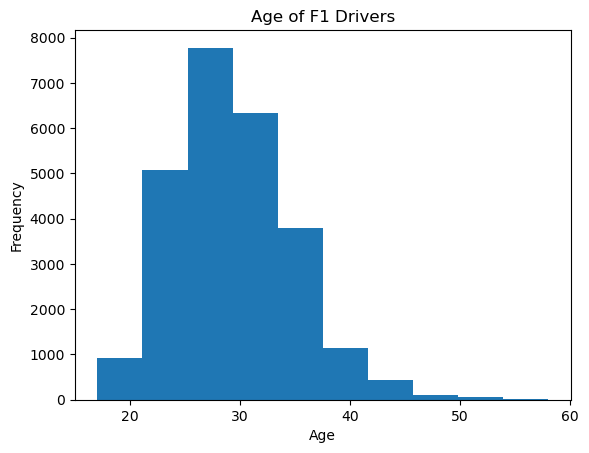

In [8]:
plt.hist(merged_data2["Age"]);
plt.xlabel("Age");
plt.ylabel("Frequency");
plt.title("Age of F1 Drivers");

Here, we can see that the age of drivers in F1 is fairly symmetric and approximately normal, with an average of around 28 years old. This is particularly interesting because our regression suggests that age is negatively correlated with position order, so we might expect a left tail as drivers do not join the competition until they are older for fear of lack of experience. Yet, we do not see this, which may suggest that young drivers are overconfident in their abilities. 

<h2 style="text-align: center; color: purple;" markdown="1">Lewis Hamilton vs Max Verstappen Grid Position Analysis</h2>


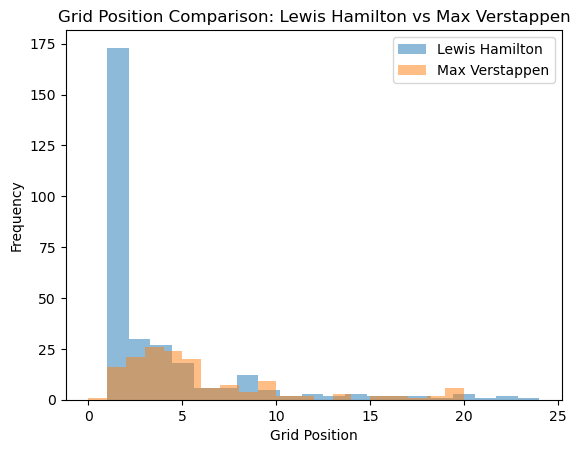

In [9]:
hamilton_data = merged_data2[merged_data2["driverId"] == 1]
verstappen_data = merged_data2[merged_data2["driverId"] == 830]

plt.hist(hamilton_data["grid"], bins=20, alpha=0.5, label="Lewis Hamilton")
plt.hist(verstappen_data["grid"], bins=20, alpha=0.5, label="Max Verstappen")
plt.xlabel("Grid Position")
plt.ylabel("Frequency")
plt.title("Grid Position Comparison: Lewis Hamilton vs Max Verstappen")
plt.legend()
plt.show()

In this plot, it is interesting to compare two of F1's most recent successful drivers, Lewis Hamilton and Max Verstappen. Over the past five years, they have been roughly equally succesful, so it is interesting to compare their distribution of grid positions. From the graph, we can see that Lewis Hamilton has qualified in the first grid position a much higher percentage of the time than Max Verstappen. The most logical explanation for this is that Lewis Hamilton is a better driver than Max Verstappen without other drivers on the track, and Verstappen is better than Hamilton when there are other drivers, given that they have both been equally succesful recently. 

<h2 style="text-align: center; color: purple;" markdown="1">Discussion</h2>


In conclusion, this analysis provides valuable insight into how important qualification and age are in predicting results in F1. We see that there is a signifigant advantage to placing higher in qualification upon final race position, and that there is a benefit to being older in F1. These results could prove important to F1 teams who are attempting to optimize their car and driver selection to finish best in races. As we have demonstrated that grid position has a signigifant effect, F1 teams may consider altering their cars to be more aerodynamic during the qualification process where this no possibility to get in the slip stream of a driver that is ahead. Additionally, F1 teams could use the signifigance of the age variable to consider using drivers who have more experience, or doing a deeper dive into why older drivers have better final positions on average. 